This is script will figure out travel times from different runs

In [2]:
import argparse
import pandas

# declare some column names
travelTime = 'travelTime'
startTime = 'startTime'
endTime = 'endTime'
distance = 'distance'
id = 'personId'
tripNumber = 'tripNo'
mode = 'mainMode'

def parse_args(args):
    parser = argparse.ArgumentParser()
    parser.add_argument('-f', '--files', nargs='+', required=True)
    parser.add_argument('-n', '--names', nargs='+', required=True)
    return parser.parse_args(args)

def read_csv(listOfFiles, listOfNames):
    
    assert(len(listOfFiles) == len(listOfNames)), 'number of files and scenario names should be equal but was: (' + str(len(listOfFiles)) + '/' + str(len(listOfNames)) + ')'
    
    result = []

    for file, name in zip(listOfFiles, listOfNames):
        scenario = pandas.read_csv(file, usecols=[id, tripNumber, startTime, endTime, distance, mode])
        scenario.set_index([id, tripNumber], inplace=True)
        scenario.sort_index(inplace=True)
        scenario[travelTime] = scenario[endTime] - scenario[startTime]
        result.append(scenario)
    return result

In [3]:
dataPath = "C:\\Users\\Janekdererste\\Desktop\\nemo_analysis\\"
args = parse_args([
    '-f', dataPath + 'base-case.csv', dataPath + 'healthy.csv', dataPath + 'deurb-no-drt.csv', dataPath + 'deurb-low-fare.csv', dataPath + 'smart.csv',
    '-n', 'Basisfall', 'Gesund & Nachhaltig', 'Deurb !Drt', 'Deurb', 'Smart'
])

dataFrames = read_csv(args.files, args.names)
data = pandas.concat(dataFrames, keys=args.names, names=['RunId', id, tripNumber])
#print(data.head(10))
data.head(10)

startTime  endTime      distance mainMode  \
RunId     personId tripNo                                              
Basisfall 54804601 0         24903.0  27398.0  13001.306360      car   
                   1         32565.0  34230.0   4781.294600      car   
                   2         34230.0  35390.0   2302.954800      car   
                   3         41131.0  42675.0   4047.200370      car   
                   4         42675.0  43419.0   1608.864389      car   
                   5         43419.0  46989.0  14864.202568      car   
          54822301 0         22837.0  25171.0  19651.739046      car   
                   1         49188.0  51108.0   9440.114341      car   
                   2         55531.0  57886.0  12267.871932      car   
          54847601 0         21487.0  24319.0  30129.437690      car   

                           travelTime  
RunId     personId tripNo              
Basisfall 54804601 0           2495.0  
                   1           1665.0  
                   2           1160.0  
                   3           1544.0  
                   4            744.0  
                   5           3570.0  
          54822301 0           2334.0  
                   1           1920.0  
                   2           2355.0  
          54847601 0           2832.0

In [4]:
#filter unplausible walk trips
data['speed'] = data[distance] / data[travelTime]
filtered = data.query('speed > 1 and speed < 2')
# select the mode and the travel time
travelTimes = filtered[[travelTime, mode]]


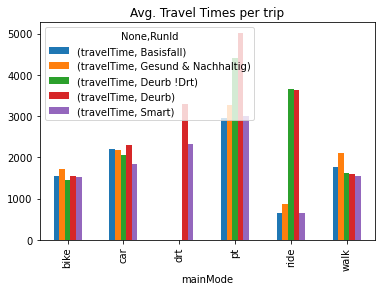

In [5]:
# group by mode and by run id
grouped = travelTimes.groupby([mode, 'RunId']).mean()
# unstack the multi-index into two columns for both run ids and then plot
grouped.unstack(level='RunId').plot.bar(title='Avg. Travel Times per trip')

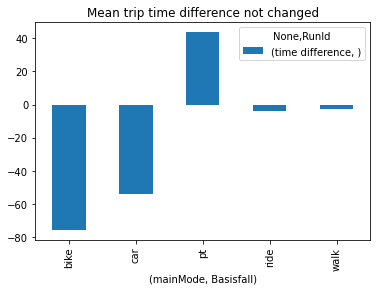

In [6]:
# compute time differences between base and scenario-case
baseCase = 'Basisfall'
policyCase = 'Deurb !Drt'
unstacked_travel_times = travelTimes.unstack(level='RunId')
unstacked_travel_times['time difference'] = unstacked_travel_times[travelTime, policyCase] - unstacked_travel_times[travelTime, baseCase]

# select trips which have the same mode in both scenarios
is_same_mode = unstacked_travel_times[mode, baseCase] == unstacked_travel_times[mode, policyCase]
differences_same_mode = unstacked_travel_times[is_same_mode]

#print(differences_same_mode)

baseCaseMainMode = differences_same_mode.xs([(mode, baseCase), ('time difference','')], axis=1)
mean = baseCaseMainMode.groupby((mode, baseCase)).mean()
mean.plot.bar(title='Mean trip time difference not changed')

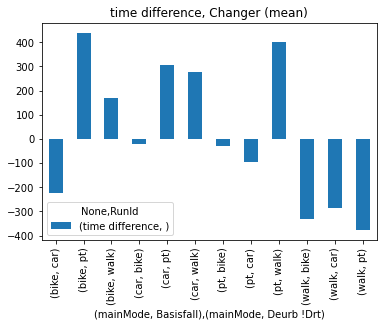

In [7]:
# select the ones which have different modes in scenario and base case
is_not_same_mode = unstacked_travel_times[mode, baseCase] != unstacked_travel_times[mode, policyCase]
different_mode = unstacked_travel_times[is_not_same_mode]

#print(different_mode)

baseCaseMainMode = different_mode.xs([(mode, baseCase),(mode, policyCase), ('time difference', '')], axis=1)
mean = baseCaseMainMode.groupby([(mode, baseCase), (mode, policyCase)]).mean()
mean.plot.bar(title='time difference, Changer (mean)')